# Time Series Analysis and Fourier Methods


## GeoInfo Tutorial Outline

1. Some initial intuition on the FFT
2. Computing the PSD (or amplitude spectrum)
3. Good Practices to dealing with Fourier transforms
4. Cross-correlation
5. Deconvolution

### Instructor: Germán A. Prieto (gaprietogo@unal.edu.co)

We spent some time reviewing some of the basics of the Fourier Transform and how that applies to finite length and discretely sampled data using the DFT.

Let's start with some basic intuition and learning how most algorithms of the FFT store the data once the FFT is computed. As we have seen in previous lectures, Obspy and probably other seismology packages will be able to do some of this stuff with a single command (compute the PSD, do cross-correlations, etc.), but in many cases, if you want to work with large amounts of data or do something different, you will probably have to implement the codes yourself. 

And it is fun to do it yourself anyways. Just don't reinvent the wheel (the FFT has been around for at least 60 years) so don't need to write the FFT yourself. 


Import basic packages that we will use. 

In [19]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt
import obspy # manejar datos
from obspy.clients.fdsn import Client  # Descargar datos
import time

## Basic example of the FFT

As you might recall, the FT of a real signal, is symmetric $\hat{f}(\nu)=\hat{f}(-\nu)$.

Let's get two real-valued random sequences, with 10 and 11 points, zero-mean and $\sigma=0.5$.

In [6]:
nx = 10
ny = 11
x = np.random.normal(0.0,0.5,(nx,1))
y = np.random.normal(0.0,0.5,(ny,1))
print(x)
print('')
print(y)

[[ 0.41740402]
 [ 0.29224199]
 [-0.07867369]
 [ 0.58163803]
 [ 0.25433412]
 [-0.10517739]
 [ 0.13148263]
 [-0.17097492]
 [ 0.39160437]
 [ 0.49346075]]

[[-0.1816984 ]
 [-0.67232438]
 [ 0.02922092]
 [-0.25398879]
 [ 0.94565745]
 [ 0.4302738 ]
 [ 0.05470398]
 [ 0.05197395]
 [ 0.19526844]
 [ 0.68264992]
 [-0.03758892]]


#### Compute the FFT of each sequence.

Notice the symmetry of the transformed data. Also, how the first point ($\nu=0$ Hz) is real, while the rest is complex.

Notice also the difference between the FFT of an even sequence ($x$) and an odd sequence ($y$). 

In [7]:
fx = scipy.fft.fft(x,axis=0) #  scipy.fft.ifft() para inversa
fy = scipy.fft.fft(y,axis=0)
print(fx)
print('')
print(fy)

# Se observa que el resultado es simétrico 

[[ 2.20733992-0.j        ]
 [ 0.81589498-0.22245331j]
 [ 0.08884639+1.02700643j]
 [ 0.47807704+0.240484j  ]
 [-0.41194977-0.97255474j]
 [ 0.02496298-0.j        ]
 [-0.41194977+0.97255474j]
 [ 0.47807704-0.240484j  ]
 [ 0.08884639-1.02700643j]
 [ 0.81589498+0.22245331j]]

[[ 1.24414795-0.j        ]
 [-1.59347928+0.6010171j ]
 [-0.62043002+2.03226945j]
 [-0.26642756-0.73147471j]
 [-0.6232658 +0.1656604j ]
 [ 1.48218745+0.60625726j]
 [ 1.48218745-0.60625726j]
 [-0.6232658 -0.1656604j ]
 [-0.26642756+0.73147471j]
 [-0.62043002-2.03226945j]
 [-1.59347928-0.6010171j ]]


Explicación : frecuencia 0 al principio, como se veía en el final de la gráfica de transoframdas de fourier

Scipy, and in general the FFTW algorithm, have a version of the FFT for a real sequence, 
that returns the transform only with the unique number of Fourier coefficients needed to describe the signal. 

For $nx$ even, the number of frequency points is $nf=(nx/2)+1$, that is $nx=10$, $nf=6$

For $ny$ odd,  the number of frequency points is $nf=(nx+1)/2$, that is $ny=11$, $nf=6$

a partir de nf comienza la reflexión que se evidencia en el bloque anterior, nf = número de frecuencia


If you are dealing with a complex time series, or if you want to do correlations, coherence, deconvolution, you need to keep the entire fourier transform. I recommend to use the `scipy.fft.fft` and just keep in mind $nf$ if you want to plot the PSD. 

In [8]:
fx = scipy.fft.rfft(x,axis=0)  # Python sabe al poner r que la señal es real
fy = scipy.fft.rfft(y,axis=0)  # por lo tanto solo da los nf=6 en este caso
print(fx)
print(fy)

[[ 2.20733992+0.j        ]
 [ 0.81589498-0.22245331j]
 [ 0.08884639+1.02700643j]
 [ 0.47807704+0.240484j  ]
 [-0.41194977-0.97255474j]
 [ 0.02496298+0.j        ]]
[[ 1.24414795+0.j        ]
 [-1.59347928+0.6010171j ]
 [-0.62043002+2.03226945j]
 [-0.26642756-0.73147471j]
 [-0.6232658 +0.1656604j ]
 [ 1.48218745+0.60625726j]]


#### What frequency is represented for the FFT

We did not discuss this in the lecture part, but `scipy` (as well as `numpy`) have functions to help you with that.

The Nyquist frequency in our example with $dt=1.0 s$, is $f_{nyq}=0.5=1/dt$. 

Note that the frequency array is slightly different, even though $nf$ is the same for both. 

In [9]:
freqx = scipy.fft.fftfreq(nx)
freqy = scipy.fft.fftfreq(ny)
print(freqx)
print(freqy)

[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]
[ 0.          0.09090909  0.18181818  0.27272727  0.36363636  0.45454545
 -0.45454545 -0.36363636 -0.27272727 -0.18181818 -0.09090909]


In [10]:
freq_long = scipy.fft.fftfreq(100*nx)
print(freq_long[0:3])

# Se observa que la tasa de frecuencia es mucho mas corta, algo corto en tiempo
# solo 100 ptos, tiene cortica resolución en frecuencia

[0.    0.001 0.002]


#### Key things to remember

The FFT algorithm (as implemented) displays first the positive frequencies, and then the negative frequencies.

Scipy puts the Nyquist frequency as a negative frequency (don't know why???).

If the number of points of the time series $nx$ is greater, the frequency sampling $df$ is smaller. **Be careful, smaller frequency sampling, does not mean higher resolution** for example when applying zero-padding.   

# Exercise 1  Tarea

First, generate a few signals as a sum if sines.

Once we are done, compute the FFT and display your results. 

Comment on what you have learned. 


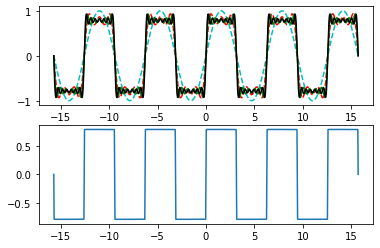

(1001, 8)


In [73]:
# Create boxcar series with sines

import numpy as np
import matplotlib.pyplot as plt

# Create x vector
pi = np.pi
x  = np.linspace(-5*pi,5*pi,1001)
dx = x[2]-x[1]

# The box car functions

# Longer version of sines
z     = np.zeros(len(x))
yfull = np.zeros((len(x),8))
kmax  = 10000

icnt  = 0
for k in range(kmax):
    if (k%2 == 0):
        continue
    z = z + 1/k*np.sin(k*x)
    if (icnt<7):
        yfull[:,icnt] = z
        icnt = icnt + 1
yfull[:,icnt] = z

fig = plt.figure()
ax  = fig.add_subplot(211)
ax.plot(x,yfull[:,0],'c--')
ax.plot(x,yfull[:,2],'r--')
ax.plot(x,yfull[:,4],'g-')
ax.plot(x,yfull[:,6],'k-')
ax  = fig.add_subplot(212)
ax.plot(x,yfull[:,7])
plt.show()

print(np.shape(yfull))

# Hacer transformada de fourier por columnas(a cada una de 'yfull') 

# First use of the FFT with this data

- How do you plot the FFT results?
- What can you interpret from the plots? 
- Do you see a difference between real and imaginary parts?

0.031415926535897754 31.447342462433653 0.0317991894289503


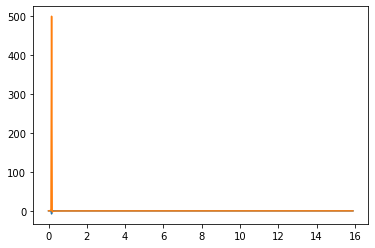

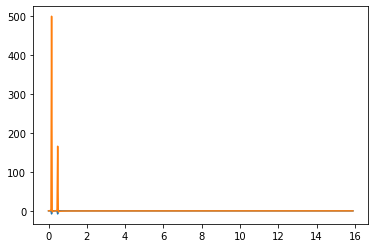

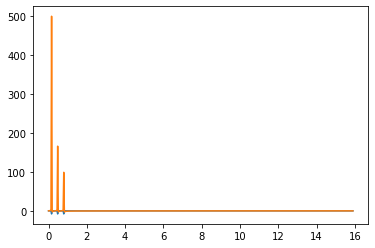

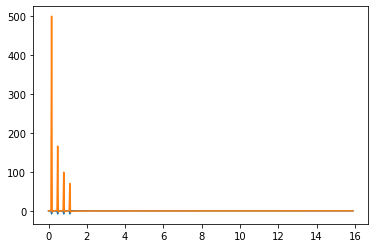

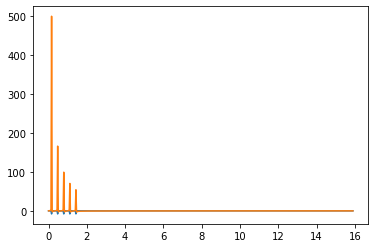

In [79]:
ndat = 8
npts = len(x)
if (npts%2==0):
    nf = int(round(npts/2)+1)
else:
    nf = int(round((npts+1)/2))
freq= scipy.fft.fftfreq(npts,dx)
df = freq[1]

print(dx,npts*dx,df)


for i in range(5):
    ft_y = scipy.fft.fft(yfull[:,i],npts)  # npt es el número de puntos
    
    fig=plt.figure()
    ax= fig.add_subplot(111)
    ax.plot(freq[0:nf],np.real(ft_y[0:nf]))
    ax.plot(freq[0:nf],np.imag(ft_y[0:nf]))
    plt.ion()
    time.sleep(0.4)
plt.show()

In [46]:
help(plt.hold())

AttributeError: module 'matplotlib.pyplot' has no attribute 'hold'

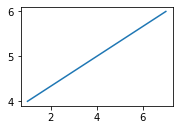

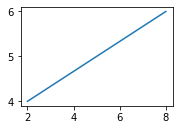

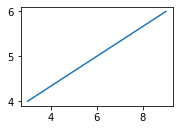

In [112]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

for i in range(3):

    fig=plt.figure()
    ax= fig.add_subplot(111)
    ax.plot(a[:,i],a[1,:])
    time.sleep(1)
    plt.show()
    ax.clear()

In [110]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(1,1,2)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for phase in np.linspace(0, 10*np.pi, 500):
    line1.set_ydata(np.sin(x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.show()
    

ValueError: num must be 1 <= num <= 1, not 2

<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim

def plot_cont(fun, xmax):
    y = []
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    def update(i):
        yi = fun()
        y.append(yi)
        x = range(len(y))
        ax.clear()
        ax.plot(x, y)
        print( i, ': ', yi)

    a = anim.FuncAnimation(fig, update, frames=xmax, repeat=False)
    plt.show()

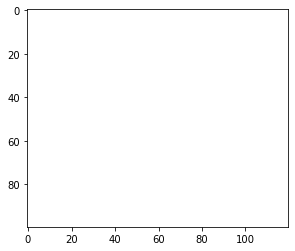

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()

In [63]:
help(animation.ArtistAnimation)

Help on class ArtistAnimation in module matplotlib.animation:

class ArtistAnimation(TimedAnimation)
 |  ArtistAnimation(fig, artists, *args, **kwargs)
 |  
 |  Animation using a fixed set of `.Artist` objects.
 |  
 |  Before creating an instance, all plotting should have taken place
 |  and the relevant artists saved.
 |  
 |  Parameters
 |  ----------
 |  fig : `~matplotlib.figure.Figure`
 |      The figure object used to get needed events, such as draw or resize.
 |  artists : list
 |      Each list entry is a collection of artists that are made visible on
 |      the corresponding frame.  Other artists are made invisible.
 |  interval : int, default: 200
 |      Delay between frames in milliseconds.
 |  repeat_delay : int, default: 0
 |      The delay in milliseconds between consecutive animation runs, if
 |      *repeat* is True.
 |  repeat : bool, default: True
 |      Whether the animation repeats when the sequence of frames is completed.
 |  blit : bool, default: False
 |     

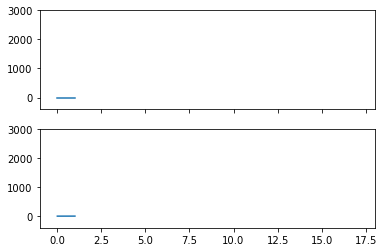

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation

x = [1,1]
y = [1,2]

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
line1, = ax1.plot(x)
line2, = ax2.plot(y)
ax1.set_xlim(-1,18)
ax1.set_ylim(-400,3000)


def update(i):
    x.append(x[-1]+x[-2])
    line1.set_data(range(len(x)), x)
    y.append(y[-1]+y[-2])
    line2.set_data(range(len(y)), y)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=14, repeat=False)   
plt.show()

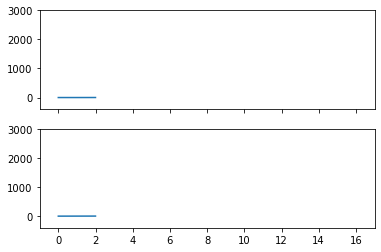

In [66]:
import matplotlib.pyplot as plt

x = [1,1]
y = [1,2]

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
line1, = ax1.plot(x)
line2, = ax2.plot(y)
ax1.set_xlim(-1,17)
ax1.set_ylim(-400,3000)
plt.ion()

for i in range(15):
    x.append(x[-1]+x[-2])
    line1.set_data(range(len(x)), x)
    y.append(y[-1]+y[-2])
    line2.set_data(range(len(y)), y)

    plt.pause(0.5)

plt.ioff()    
plt.show()

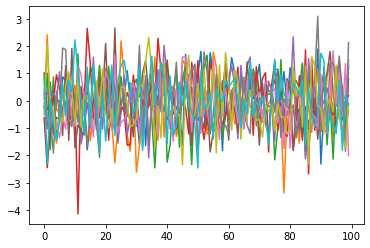

In [93]:

import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=False)
    display.display(pl.gcf())
    time.sleep(1.0)
display.clear_output(wait=True)


In [82]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
%matplotlib inline

i = pd.date_range('2013-1-1',periods=100,freq='s')

while True:
    try:
        plt.plot(pd.Series(data=np.random.randn(100), index=i))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
        plt.clf()

SyntaxError: unexpected EOF while parsing (<ipython-input-82-7aae2d705b00>, line 16)

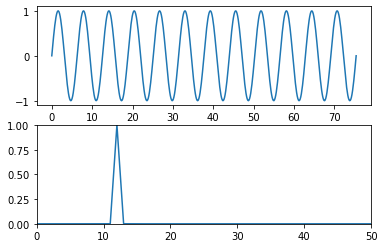

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

x = np.linspace(0,24*np.pi,512)
y = np.sin(x)

def fft(x):
    fft = np.abs(np.fft.rfft(x))
    return fft**2/(fft**2).max()

fig, (ax1,ax2) = plt.subplots(nrows=2)
line1, = ax1.plot(x,y)
line2, = ax2.plot(fft(y))
ax2.set_xlim(0,50)
ax2.set_ylim(0,1)

def update(i):
    y = np.sin((i+1)/30.*x)
    line1.set_data(x,y)
    y2 = fft(y)
    line2.set_data(range(len(y2)), y2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=60, repeat=True)  
plt.show()

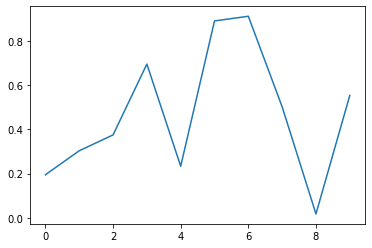

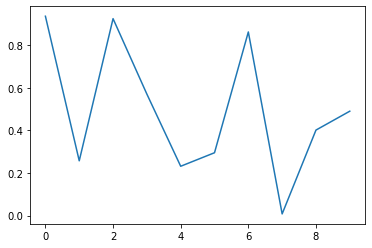

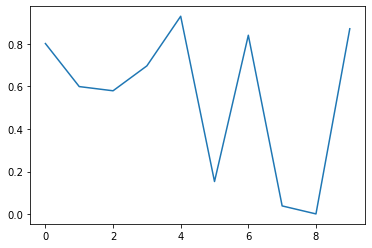

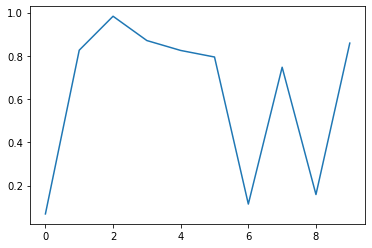

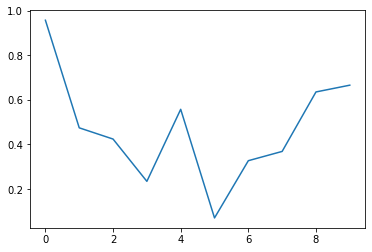

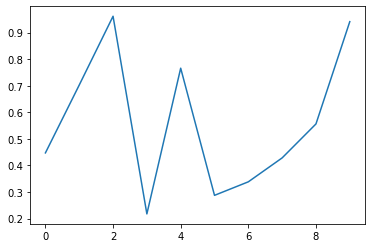

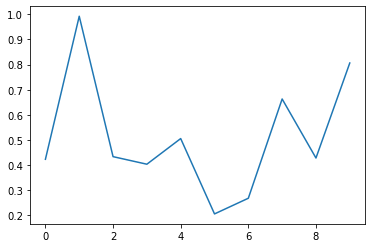

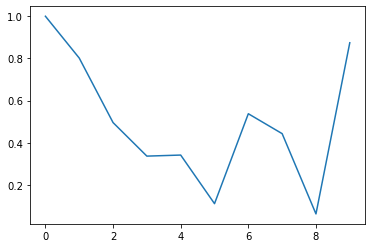

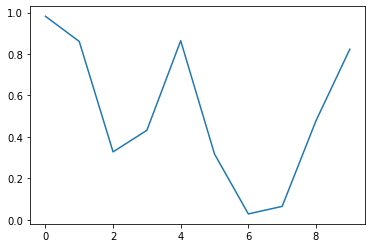

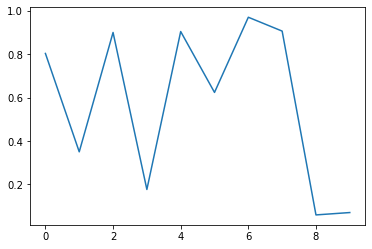

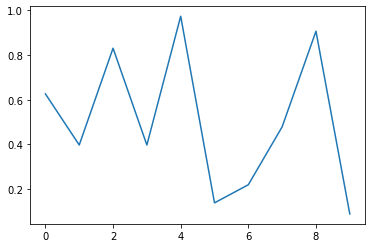

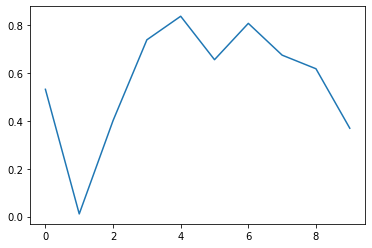

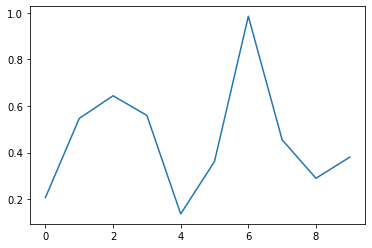

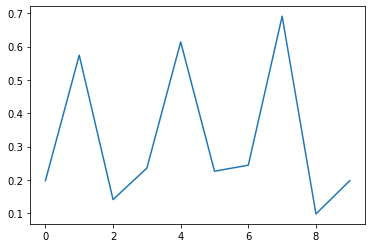

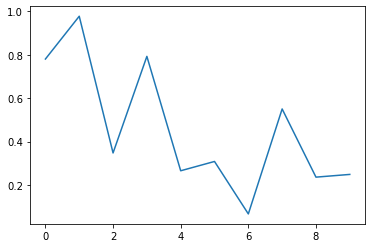

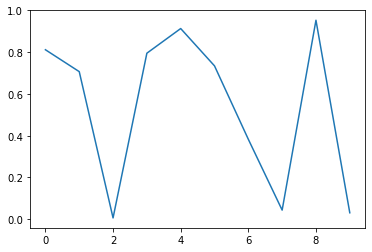

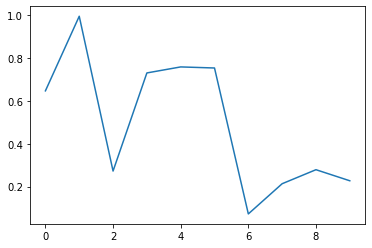

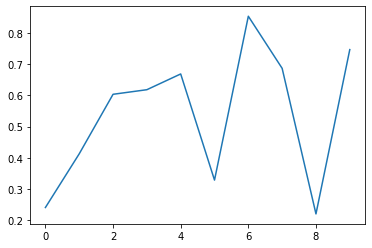

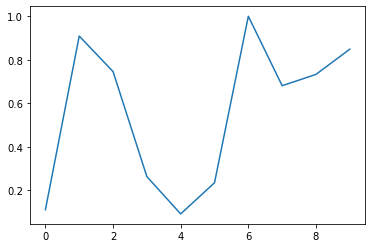

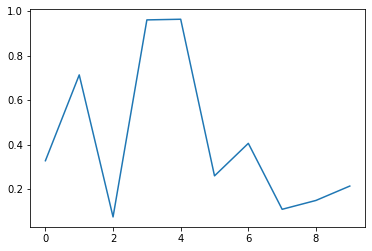

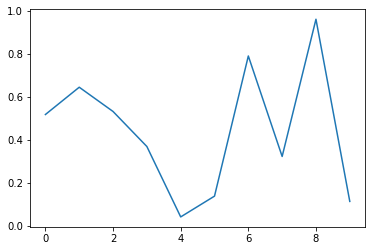

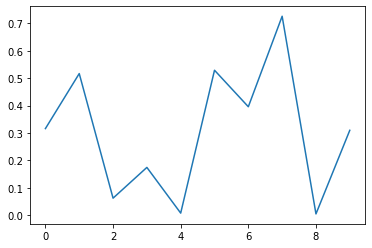

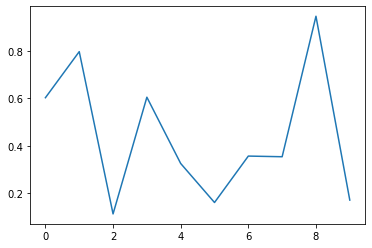

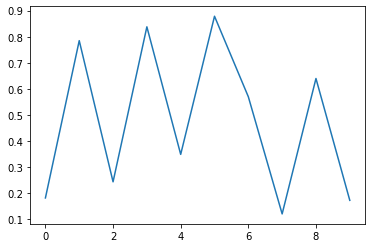

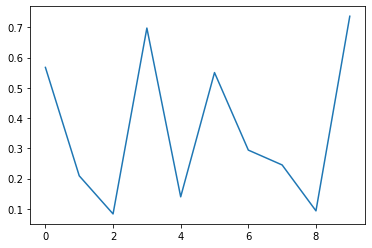

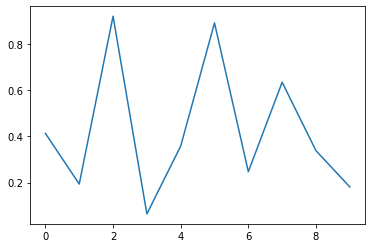

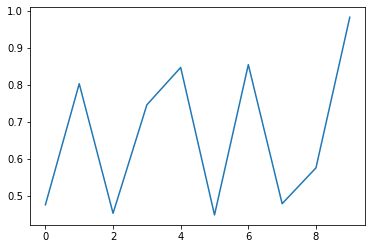

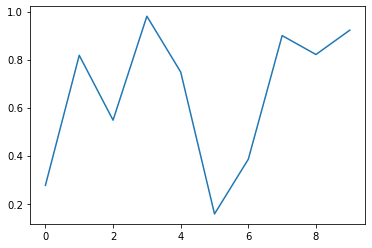

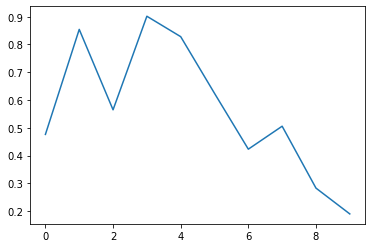

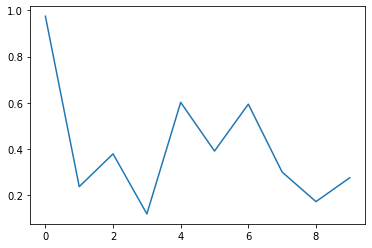

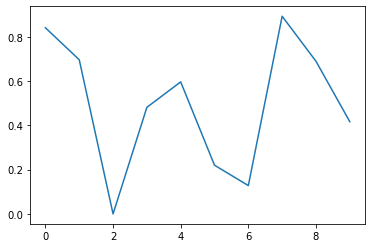

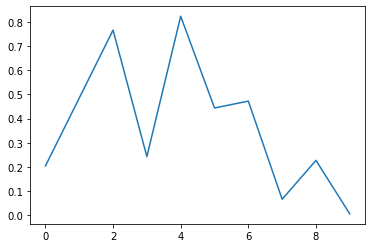

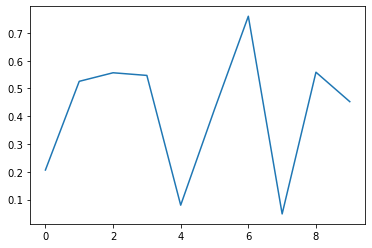

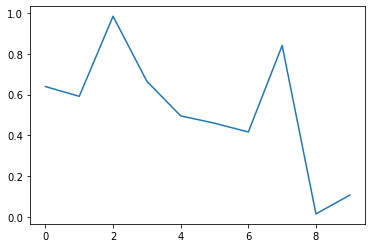

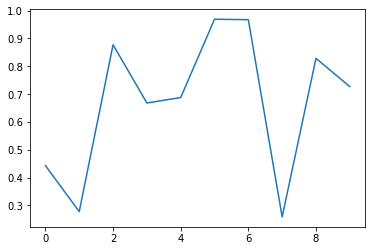

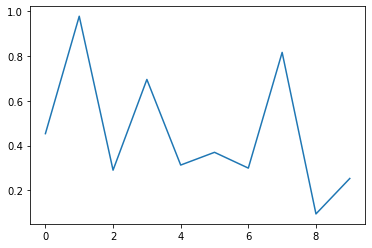

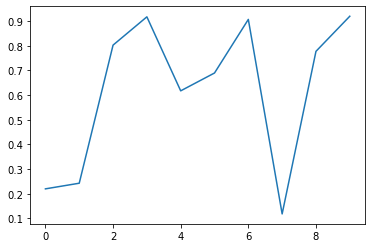

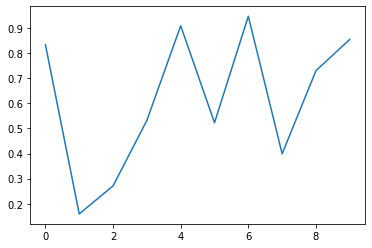

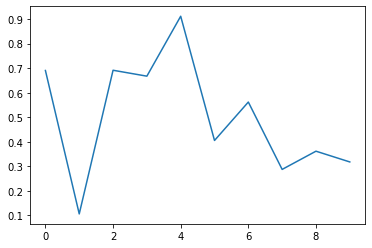

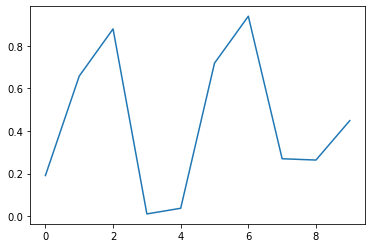

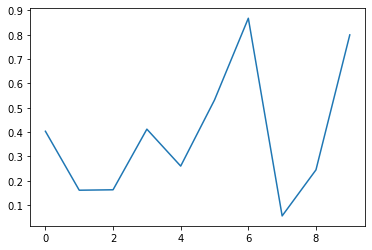

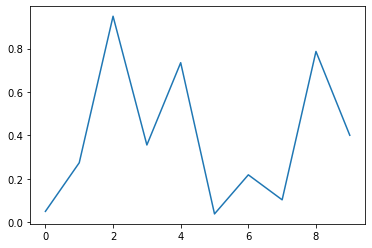

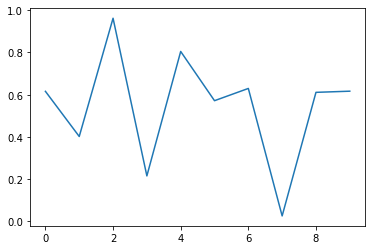

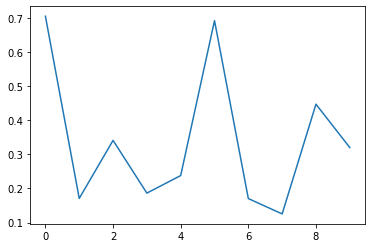

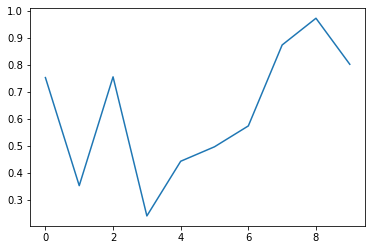

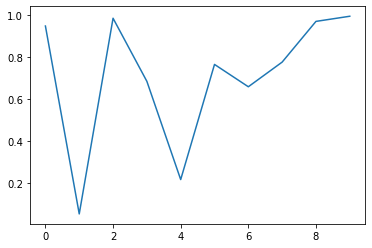

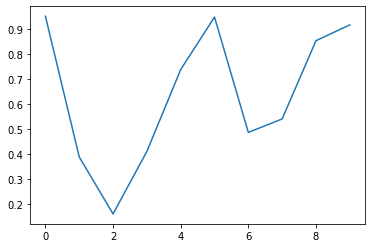

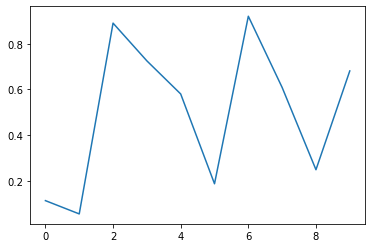

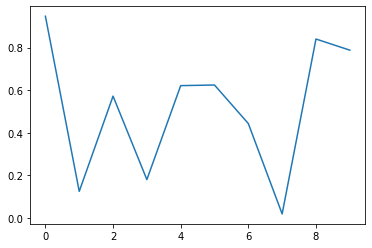

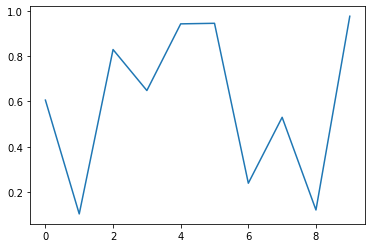

<Figure size 432x288 with 0 Axes>

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import os

def borrarPantalla(): #Definimos la función estableciendo el nombre que queramos
    if os.name == "posix":
       os.system ("clear")
    elif os.name == "ce" or os.name == "nt" or os.name == "dos":
       os.system ("cls")

plt.ion()
for i in range(50):
    y = np.random.random([10,1])
    plt.plot(y)
    plt.show()
    plt.pause(0.2)
    plt.clf()
    borrarPantalla()
    
    

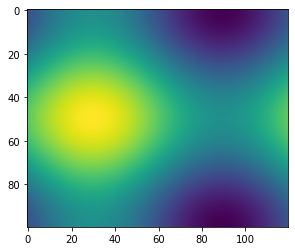

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y)) 